In [1]:
using InteractiveUtils, Pkg, Revise
versioninfo(); Pkg.status()

Julia Version 1.9.1
Commit 147bdf428cd (2023-06-07 08:27 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × AMD EPYC 7R32
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver2)
  Threads: 11 on 32 virtual cores
Environment:
  JULIA_NUM_THREADS = 10
Status `~/src/AdvancedHMC.jl/research/tests/Project.toml`
⌃ [c75e803d] AdaptiveRejectionSampling v0.1.1
  [0bf59076] AdvancedHMC v0.4.6 `~/src/AdvancedHMC.jl`
  [6e4b80f9] BenchmarkTools v1.3.2
  [863f3e99] Comonicon v1.0.5
  [163ba53b] DiffResults v1.1.0
⌃ [31c24e10] Distributions v0.25.95
⌅ [366bfd00] DynamicPPL v0.22.4
⌃ [6a86dc24] FiniteDiff v2.20.0
  [f6369f11] ForwardDiff v0.10.35
⌃ [7073ff75] IJulia v1.24.0
  [6d524b87] MCMCDebugging v0.2.1
⌃ [91a5bcdd] Plots v1.38.13
⌃ [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [e0db7c4e] ReTest v0.3.2
  [37e2e3b7] ReverseDiff v1.14.6
  [a8a75453] StatProfilerHTML v1.5.0
  [8a639fad] VecTargets v0.2.0 `https://github.com/xukai92/VecTargets.jl.git#main`
In

In [2]:
using PyPlot: matplotlib
const plt = matplotlib.pyplot
plt.style.use("bmh")
using Statistics, AdvancedHMC
includet("../src/relativistic_hmc.jl")
includet("../src/riemannian_hmc.jl")
includet("../src/riemannian_hmc_utility.jl")

[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
┌ Warning: skipping callee #step#24 (called by step) due to UndefRefError()
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/30gbF/src/signatures.jl:292


In [3]:
using FiniteDiff: finite_difference_gradient, finite_difference_hessian, finite_difference_jacobian
using AdvancedHMC: neg_energy, energy

function check(a, b)
    @show a, b
    @show maximum(abs.(a - b))
    @show norm(a - b, 2)
end

let hps = (; λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)
    
    target = Funnel()

    rng = MersenneTwister(1110)

    θ₀ = randn(rng, dim(target))

    ℓπ = VecTargets.gen_logpdf(target)
    ∂ℓπ∂θ = VecTargets.gen_logpdf_grad(target, θ₀)

    Vfunc, Hfunc, Gfunc, ∂G∂θfunc = prepare_sample_target(hps, θ₀, ℓπ)

    D = dim(target) # ==2 for this test
    x = zeros(D) # randn(rng, D)
    r = randn(rng, D)
    
    # metric = UnitEuclideanMetric(D)
    # metric = DiagEuclideanMetric(D)
    # metric = DenseEuclideanMetric((D,))
    
    hessmap = SoftAbsMap(hps.α)
    metric = DenseRiemannianMetric((D,), Gfunc, ∂G∂θfunc, hessmap)
    
    kinetic = RelativisticKinetic(1.0, 1.0)
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    Hamifunc = (x, r) -> energy(hamiltonian, r, x) + energy(hamiltonian, x)
    Hamifuncx = x -> Hamifunc(x, r)
    Hamifuncr = r -> Hamifunc(x, r)

    check(finite_difference_gradient(Hamifuncx, x), ∂H∂θ(hamiltonian, x, r).gradient)

    check(finite_difference_gradient(Hamifuncr, r), ∂H∂r(hamiltonian, x, r))

    dimensionwise_kinetic = DimensionwiseRelativisticKinetic(1.0, 1.0)
    dimensionwise_hamiltonian = Hamiltonian(metric, dimensionwise_kinetic, ℓπ, ∂ℓπ∂θ)

    Hamifunc = (x, r) -> energy(dimensionwise_hamiltonian, r, x) + energy(dimensionwise_hamiltonian, x)
    Hamifuncx = x -> Hamifunc(x, r)
    Hamifuncr = r -> Hamifunc(x, r)

    check(finite_difference_gradient(Hamifuncx, x), ∂H∂θ(dimensionwise_hamiltonian, x, r).gradient)

    check(finite_difference_gradient(Hamifuncr, r), ∂H∂r(dimensionwise_hamiltonian, x, r))

    @show energy(hamiltonian, r, x) energy(dimensionwise_hamiltonian, r, x)
end

;

(a, b) = ([0.25594625536545884, 1.1591363027365453], [0.2559462553842406, 1.1591363026326686])
maximum(abs.(a - b)) = 1.0387668503142322e-10
norm(a - b, 2) = 1.0556097751442198e-10
(a, b) = ([1.3373313855082443, 0.5779109055198047], [1.3373313855615807, 0.5779109054977736])
maximum(abs.(a - b)) = 5.333644637062207e-11
norm(a - b, 2) = 5.7707437024252174e-11
(a, b) = ([0.2891543412824177, 1.4239110034470495], [0.8083292483618991, 1.312496255281786])
maximum(abs.(a - b)) = 0.5191749070794814
norm(a - b, 2) = 0.530995132039567
(a, b) = ([1.6428101428835526, 0.6543716193431822], [1.6428101429724244, 0.6543716193079193])
maximum(abs.(a - b)) = 8.88717988090093e-11
norm(a - b, 2) = 9.561207560490923e-11
energy(hamiltonian, r, x) = 0.4603779387696054
energy(dimensionwise_hamiltonian, r, x) = 1.5083148619095492


Progress: 100%|█████████████████████████████████████████| Time: 0:03:47


230.495961 seconds (2.98 G allocations: 105.843 GiB, 15.23% gc time, 1.62% compilation time: 75% of which was recompilation)
Quantile error: 0.012480000000000002


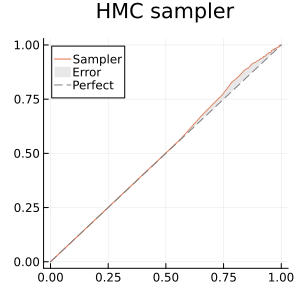

In [5]:
using Distributions, DynamicPPL

# Treating the first 2 dimensions as latent and the third as data.
@model function TuringFunnel(θ=missing, x=missing)
    if ismissing(θ)
        θ = Vector(undef, 2)
    end
    θ[1] ~ Normal(0, 3)
    s = exp(θ[1] / 2)
    θ[2] ~ Normal(0, s)
    x ~ Normal(0, s)
    return θ, x
end

# Sanity check for normal HMC
function rand_θ_given_hmc(target, hps, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    
    D = dim(target) - 1
    θ₀ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    ∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, θ₀)

    # metric = UnitEuclideanMetric(D)
    metric = DiagEuclideanMetric(D)
    # metric = DenseEuclideanMetric(D)
    # kinetic = GaussianKinetic()
    kinetic = RelativisticKinetic(hps.m, hps.c)
    # kinetic = DimensionwiseRelativisticKinetic(hps.m, hps.c)
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, θ₀, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

make_rand_θ_given_hmc(hps, target) = x -> rand_θ_given_hmc(hps, target, x)

g(θ, x) = cat(θ, x; dims=1)

using MCMCDebugging
using Logging: NullLogger, with_logger

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, m=1.0, c=1.0, ϵ=0.1, n=6, L=8)

@time res = with_logger(NullLogger()) do
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given_hmc(Funnel(3), hps_geweke); g=g)
end

using Plots: Plots

Plots.plot(res, TuringFunnel(); size=(300, 300), title="HMC sampler")

 14.211307 seconds (76.78 M allocations: 4.298 GiB, 9.90% gc time, 0.04% compilation time)


┌ Info: Average acceptance ratio
└   mean(map((s->begin
                #= In[9]:12 =#
                s.is_accept
            end), retval.stats)) = 0.554


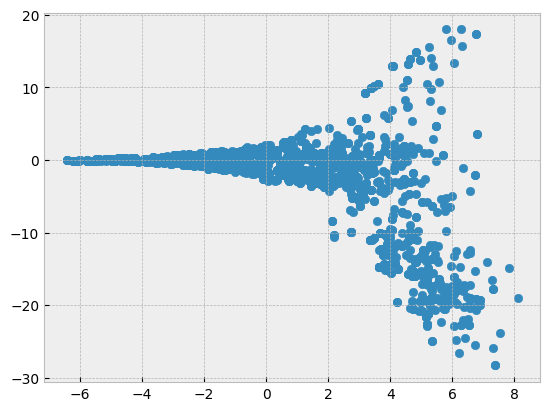

In [9]:
using Logging: NullLogger, with_logger

hps = (; target=:gaussian, n_samples=2_000, metric=:dense_euclidean, λ=1e-2, α=20.0, m=1.0, c=1.0, integrator=:lf, ϵ=0.05, n=6, L=8)

@time retval = with_logger(NullLogger()) do 
    # sample_target((; hps..., target=:funnel, kinetic=:relativistic, integrator=:lf, ϵ=0.2))
    # sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, kinetic=:gaussian, integrator=:glf))
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, kinetic=:relativistic, m=0.5, c=5.0, integrator=:glf))
    # sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, kinetic=:dimwise_relativistic, integrator=:glf))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

In [60]:
# I still need to use the hand-written one because of AD
function rand_θ_given(hps, target, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    
    D = dim(target) - 1
    θ₀ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    ∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, θ₀)
    
    _, _, Gfunc, ∂G∂θfunc = prepare_sample_target(hps, θ₀, ℓπ)

    metric = DenseRiemannianMetric((D,), Gfunc, ∂G∂θfunc, SoftAbsMap(hps.α))
    kinetic = RelativisticKinetic(hps.m, hps.c)
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, θ₀, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

make_rand_θ_given(hps, target) = x -> rand_θ_given(hps, target, x)

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, m=1.0, c=1.0, ϵ=0.1, n=6, L=8)

@time res_1 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given(hps_geweke, Funnel(3)); g=g)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:16:51


1011.823335 seconds (4.63 G allocations: 253.238 GiB, 12.41% gc time, 1.22% compilation time)


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 1000
    Parameter dimension: 2
    Data dimension: 1
    Statistic: [-8.827557625219757, -2.457759823353771, -0.7256779723140707]
    P-value: [1.0698625521328118e-18, 0.013980663860093102, 0.46803620863987677]


Quantile error: 0.10012999999999998


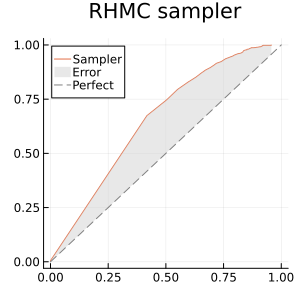

In [61]:
Plots.plot(res_1, TuringFunnel(); size=(300, 300), title="RHMC sampler")